In [1]:
from dataset import *
from evaluator import *
from torch.utils.data import DataLoader

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable
import torch.autograd as autograd

from torchvision.utils import save_image, make_grid

import matplotlib.pyplot as plt

import tqdm

path = "./Conditional_DCGAN_"

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


In [2]:
image_size = 64

trans = transforms.Compose([transforms.ToPILImage(),
                            transforms.Resize([image_size, image_size]),
                            transforms.CenterCrop([image_size, image_size]),
                            transforms.ToTensor(),
                            transforms.Normalize((0.5, 0.5, 0.5, 0.5), (0.5, 0.5, 0.5, 0.5)), # normalize to [-1, 1] for the last layer of generator is tanh()
                            ])

# preprocessing size -> 64x64
train = ICLEVRLoader("./", trans=trans, mode="train", preprocessing=None)
# test = ICLEVRLoader("./", mode="test")

batch_size = 128 # based on paper
train_loader = DataLoader(
    dataset=train, 
    batch_size=batch_size,
    num_workers = 4
)

data = json.load(open(os.path.join('./','test.json')))
obj = json.load(open(os.path.join('./','objects.json')))
test_labels = data
for i in range(len(test_labels)):
    for j in range(len(test_labels[i])):
        test_labels[i][j] = obj[test_labels[i][j]]
    tmp = np.zeros(len(obj))
    tmp[test_labels[i]] = 1
    test_labels[i] = tmp
test_labels = torch.tensor(test_labels).to(device)

> Found 18009 images...


In [3]:
class Generator(nn.Module):
    def __init__(self, n_classes, latent_dim, img_shape, n_channels):
        super(Generator, self).__init__()
        
        self.n_classes = n_classes
        self.label_emb = nn.Embedding(n_classes, n_classes)
        self.input_cnn = nn.Linear(n_classes+latent_dim, 128)

        self.main = nn.Sequential(
            # input is Z, going into a convolution
#             nn.ConvTranspose2d( img_shape, img_shape*8 , 4, 1, 0, bias=False), #input shape [batch_size, 64, 1, 1]
            nn.ConvTranspose2d( 128, img_shape*8 , 4, 1, 0, bias=False), # input shape [batch_size, 64, 2, 2]
            nn.BatchNorm2d(img_shape*8),
            nn.ReLU(True),
            # state size. (img_shape*8) x 4 x 4
            nn.ConvTranspose2d(img_shape * 8, img_shape * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(img_shape * 4),
            nn.ReLU(True),
            # state size. (img_shape*4) x 8 x 8
            nn.ConvTranspose2d( img_shape * 4, img_shape * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(img_shape * 2),
            nn.ReLU(True),
            # state size. (img_shape*2) x 16 x 16
            nn.ConvTranspose2d( img_shape * 2, img_shape, 4, 2, 1, bias=False),
            nn.BatchNorm2d(img_shape),
            nn.ReLU(True),
            # state size. (img_shape) x 32 x 32
            nn.ConvTranspose2d( img_shape, n_channels, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (n_channels) x 64 x 64
        )

    def forward(self, noise, labels):
        gen_input = torch.cat((labels, noise), -1).float()
        gen_input = self.input_cnn(gen_input).view(-1, 128, 1, 1)
        img = self.main(gen_input)
        return img


class Discriminator(nn.Module):
    def __init__(self, n_classes, img_shape):
        super(Discriminator, self).__init__()
        self.n_classes = n_classes
        self.img_shape= img_shape
        self.label_embedding = nn.Embedding(n_classes, n_classes)
        
        self.label_linear = nn.Linear(n_classes, img_shape*img_shape)        
        
        self.main = nn.Sequential(
            # input is (n_classes) x 64 x 64
            nn.Conv2d(4, img_shape, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (img_shape) x 32 x 32
            nn.Conv2d(img_shape, img_shape * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(img_shape * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (img_shape*2) x 16 x 16
            nn.Conv2d(img_shape * 2, img_shape * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(img_shape * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (img_shape*4) x 8 x 8
            nn.Conv2d(img_shape * 4, img_shape * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(img_shape * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (img_shape*8) x 4 x 4
            nn.Conv2d(img_shape * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        # Concatenate label embedding and image to produce input
        labels = self.label_linear(labels.float()).view(-1, 1, self.img_shape, self.img_shape)
        d_in = torch.cat((img, labels), 1)
        validity = self.main(d_in).view(-1, 1)

        return validity

In [4]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# loss function
adversarial_loss = torch.nn.BCELoss()

# model 
n_classes = 24
latent_dim = 100
img_shape = 64
n_channels = 3
generator = Generator(n_classes, latent_dim, img_shape, n_channels).to(device)
discriminator = Discriminator(n_classes, img_shape).to(device)

generator.apply(weights_init)
discriminator.apply(weights_init)

# optimizer 
lr = 0.0002
b1 = 0.5
b2 = 0.999
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

In [5]:
def save_acc(filename, g_loss, d_loss, score):
    try:
        acc = np.load(filename)
        np_g_loss = acc['g_loss']
        np_d_loss = acc['d_loss']
        np_score = acc['score']
        np_g_loss = np.append(np_g_loss, g_loss)
        np_d_loss = np.append(np_d_loss, d_loss)
        np_score = np.append(np_score, score)
        np.savez(filename, g_loss=np_g_loss, d_loss=np_d_loss, score=np_score)
    except:
        g_loss = np.array(g_loss)
        d_loss = np.array(d_loss)
        score = np.array(score)
        np.savez(filename, g_loss=g_loss, d_loss=d_loss, score=score)
        
def test_eval(generator, epoch):
    np.random.seed(0)    
    generator.eval()
    eval_model = evaluation_model()
    batch_size = test_labels.shape[0]
    z = Variable(FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim)))).to(device) # shape [batch_size, latent_dim] with normal distribution
    gen_imgs = generator(z, test_labels) # shape [batch_size, 3, 64, 64]
    if epoch % 10 == 0:
        show_image(gen_imgs)
    return eval_model.eval(gen_imgs, test_labels)

def show_image(gen_imgs):
    # step 1: convert it to [0 ,2]
    gen_imgs = gen_imgs +1
    
    # step 2: convert it to [0 ,1]
    gen_imgs = gen_imgs - gen_imgs.min()
    gen_imgs = gen_imgs / (gen_imgs.max() - gen_imgs.min())
    
    grid = make_grid(gen_imgs)
    plt.figure(figsize=(14, 14))
    plt.imshow(np.transpose(grid.detach().cpu().numpy(), (1, 2, 0)))
    plt.show()

[Epoch 1/100] [D loss: 0.516255] [G loss: 23.330163] [test score: 0.069444]
[Epoch 2/100] [D loss: 0.231700] [G loss: 14.715681] [test score: 0.083333]
[Epoch 3/100] [D loss: 0.196357] [G loss: 15.586629] [test score: 0.055556]
[Epoch 4/100] [D loss: 0.081148] [G loss: 16.615852] [test score: 0.097222]
[Epoch 5/100] [D loss: 0.131620] [G loss: 21.430229] [test score: 0.083333]
[Epoch 6/100] [D loss: 0.181045] [G loss: 22.604545] [test score: 0.111111]
[Epoch 7/100] [D loss: 0.082134] [G loss: 21.284161] [test score: 0.125000]
[Epoch 8/100] [D loss: 0.163288] [G loss: 30.356353] [test score: 0.111111]
[Epoch 9/100] [D loss: 0.036333] [G loss: 20.707737] [test score: 0.069444]


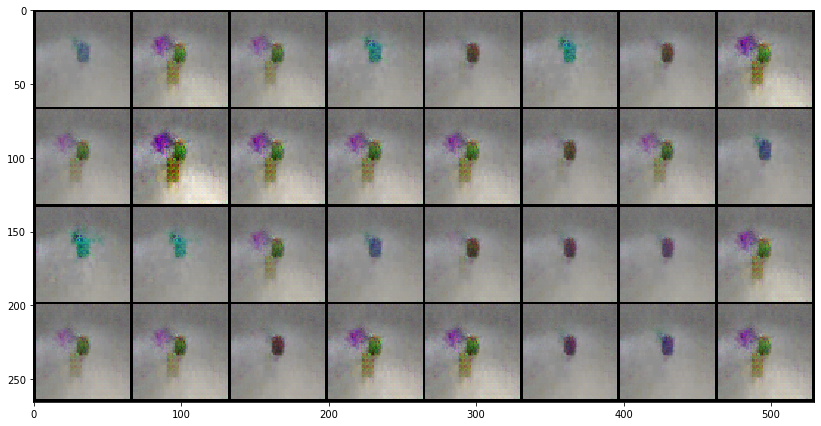

[Epoch 10/100] [D loss: 0.044165] [G loss: 23.005310] [test score: 0.111111]
[Epoch 11/100] [D loss: 0.166567] [G loss: 30.109398] [test score: 0.069444]
[Epoch 12/100] [D loss: 0.088681] [G loss: 24.105121] [test score: 0.111111]
[Epoch 13/100] [D loss: 0.064350] [G loss: 25.119948] [test score: 0.194444]
[Epoch 14/100] [D loss: 0.181741] [G loss: 28.747428] [test score: 0.180556]
[Epoch 15/100] [D loss: 0.154026] [G loss: 22.472915] [test score: 0.194444]
[Epoch 16/100] [D loss: 0.054613] [G loss: 19.561741] [test score: 0.222222]
[Epoch 17/100] [D loss: 0.150048] [G loss: 23.280610] [test score: 0.250000]
[Epoch 18/100] [D loss: 0.120200] [G loss: 22.936010] [test score: 0.236111]
[Epoch 19/100] [D loss: 0.152166] [G loss: 22.420989] [test score: 0.222222]


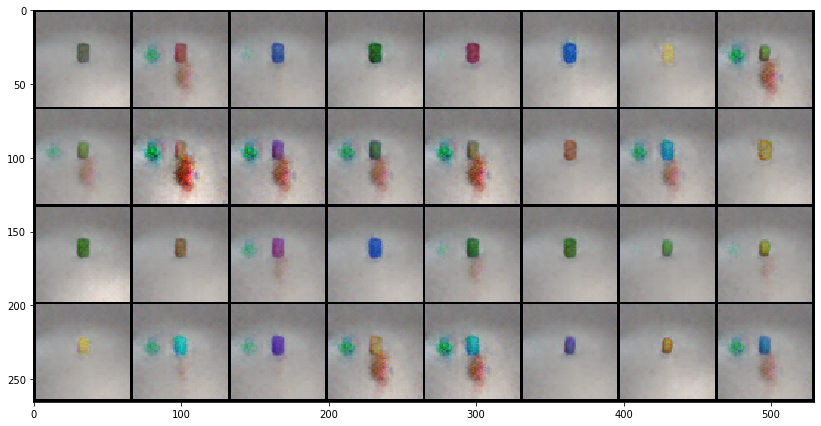

[Epoch 20/100] [D loss: 0.103960] [G loss: 22.039061] [test score: 0.263889]
[Epoch 21/100] [D loss: 0.056408] [G loss: 21.500952] [test score: 0.222222]
[Epoch 22/100] [D loss: 0.146510] [G loss: 24.715405] [test score: 0.319444]
[Epoch 23/100] [D loss: 0.157357] [G loss: 22.374183] [test score: 0.277778]
[Epoch 24/100] [D loss: 0.061507] [G loss: 20.425604] [test score: 0.305556]
[Epoch 25/100] [D loss: 0.122313] [G loss: 22.116110] [test score: 0.277778]
[Epoch 26/100] [D loss: 0.169772] [G loss: 20.161957] [test score: 0.263889]
[Epoch 27/100] [D loss: 0.189160] [G loss: 20.583914] [test score: 0.347222]
[Epoch 28/100] [D loss: 0.078336] [G loss: 19.419024] [test score: 0.361111]
[Epoch 29/100] [D loss: 0.118871] [G loss: 22.853894] [test score: 0.263889]


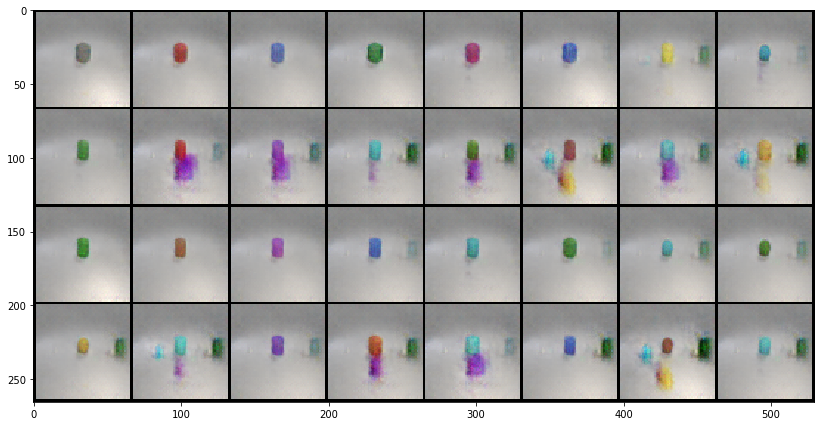

[Epoch 30/100] [D loss: 0.076810] [G loss: 21.373828] [test score: 0.319444]
[Epoch 31/100] [D loss: 0.105364] [G loss: 21.628584] [test score: 0.180556]
[Epoch 32/100] [D loss: 0.093645] [G loss: 20.084858] [test score: 0.305556]
[Epoch 33/100] [D loss: 0.144284] [G loss: 23.302608] [test score: 0.291667]
[Epoch 34/100] [D loss: 0.119736] [G loss: 21.246946] [test score: 0.333333]
[Epoch 35/100] [D loss: 0.083576] [G loss: 20.389363] [test score: 0.305556]
[Epoch 36/100] [D loss: 0.064842] [G loss: 20.655618] [test score: 0.305556]
[Epoch 37/100] [D loss: 0.106335] [G loss: 21.835981] [test score: 0.347222]
[Epoch 38/100] [D loss: 0.075757] [G loss: 21.027623] [test score: 0.291667]
[Epoch 39/100] [D loss: 0.156219] [G loss: 22.227807] [test score: 0.250000]


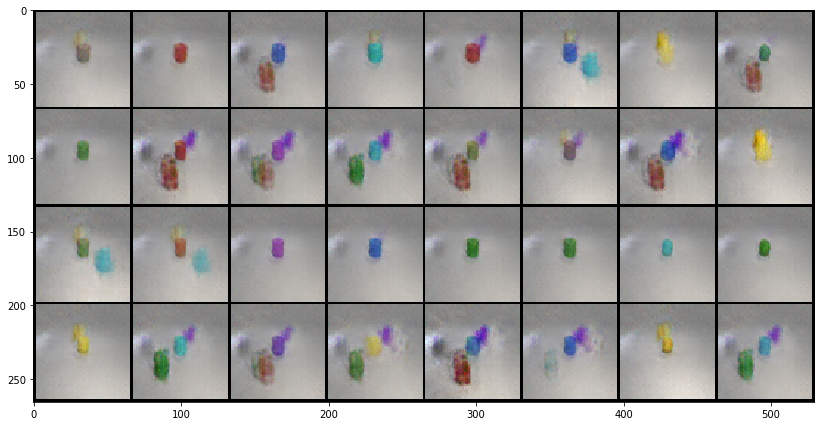

[Epoch 40/100] [D loss: 0.066181] [G loss: 21.624352] [test score: 0.319444]
[Epoch 41/100] [D loss: 0.079576] [G loss: 22.565129] [test score: 0.361111]
[Epoch 42/100] [D loss: 0.105311] [G loss: 22.543493] [test score: 0.250000]
[Epoch 43/100] [D loss: 0.056433] [G loss: 23.022557] [test score: 0.222222]
[Epoch 44/100] [D loss: 0.072296] [G loss: 23.176050] [test score: 0.222222]
[Epoch 45/100] [D loss: 0.024308] [G loss: 25.426019] [test score: 0.152778]
[Epoch 46/100] [D loss: 0.017876] [G loss: 24.670377] [test score: 0.194444]
[Epoch 47/100] [D loss: 0.139674] [G loss: 25.558494] [test score: 0.208333]
[Epoch 48/100] [D loss: 0.092688] [G loss: 24.628534] [test score: 0.208333]
[Epoch 49/100] [D loss: 0.067687] [G loss: 23.015437] [test score: 0.263889]


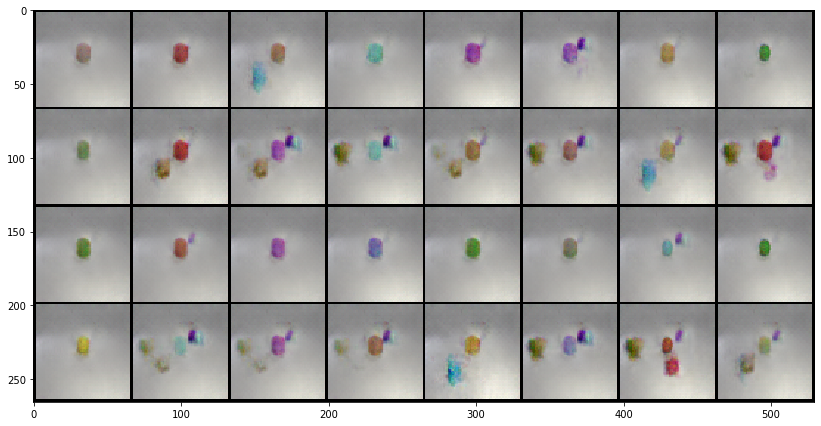

[Epoch 50/100] [D loss: 0.068191] [G loss: 24.833881] [test score: 0.250000]
[Epoch 51/100] [D loss: 0.028649] [G loss: 22.465595] [test score: 0.222222]
[Epoch 52/100] [D loss: 0.115932] [G loss: 24.225342] [test score: 0.305556]
[Epoch 53/100] [D loss: 0.018315] [G loss: 24.472515] [test score: 0.250000]
[Epoch 54/100] [D loss: 0.099064] [G loss: 24.759768] [test score: 0.250000]
[Epoch 55/100] [D loss: 0.020994] [G loss: 23.979948] [test score: 0.250000]
[Epoch 56/100] [D loss: 0.115176] [G loss: 25.106301] [test score: 0.236111]
[Epoch 57/100] [D loss: 0.106121] [G loss: 24.735341] [test score: 0.208333]
[Epoch 58/100] [D loss: 0.033193] [G loss: 22.360614] [test score: 0.277778]
[Epoch 59/100] [D loss: 0.037766] [G loss: 25.289951] [test score: 0.208333]


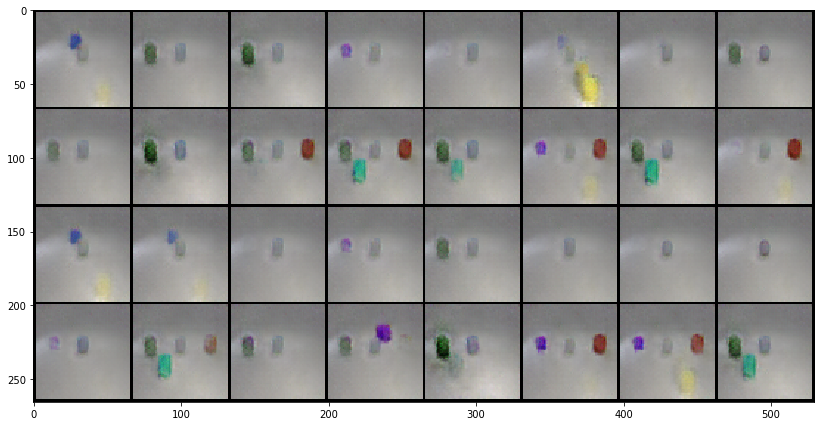

[Epoch 60/100] [D loss: 0.038192] [G loss: 28.886752] [test score: 0.111111]
[Epoch 61/100] [D loss: 0.008123] [G loss: 29.083110] [test score: 0.152778]
[Epoch 62/100] [D loss: 0.005431] [G loss: 30.417713] [test score: 0.097222]
[Epoch 63/100] [D loss: 0.003719] [G loss: 31.357664] [test score: 0.055556]
[Epoch 64/100] [D loss: 0.247496] [G loss: 39.438404] [test score: 0.125000]
[Epoch 65/100] [D loss: 0.027438] [G loss: 23.934484] [test score: 0.125000]
[Epoch 66/100] [D loss: 0.026677] [G loss: 28.170354] [test score: 0.069444]
[Epoch 67/100] [D loss: 0.012430] [G loss: 29.609026] [test score: 0.138889]
[Epoch 68/100] [D loss: 0.049543] [G loss: 34.367373] [test score: 0.166667]
[Epoch 69/100] [D loss: 0.070460] [G loss: 26.087954] [test score: 0.208333]


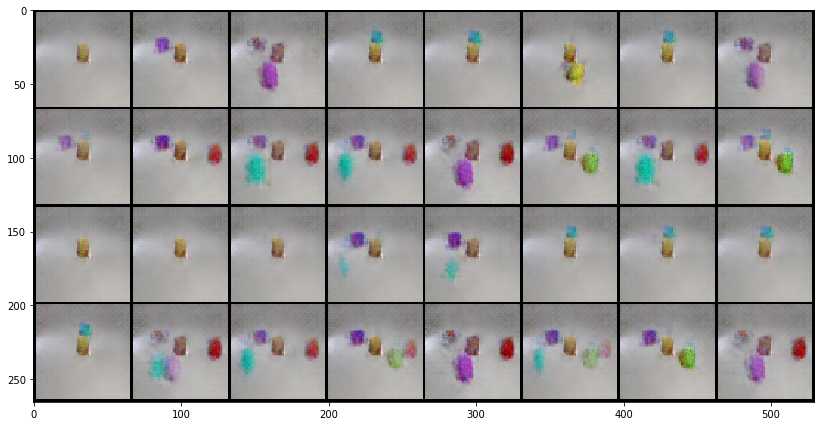

[Epoch 70/100] [D loss: 0.112538] [G loss: 27.831726] [test score: 0.111111]
[Epoch 71/100] [D loss: 0.017423] [G loss: 24.452891] [test score: 0.152778]
[Epoch 72/100] [D loss: 0.058181] [G loss: 27.164633] [test score: 0.152778]
[Epoch 73/100] [D loss: 0.081488] [G loss: 24.226891] [test score: 0.152778]
[Epoch 74/100] [D loss: 0.081732] [G loss: 24.160830] [test score: 0.194444]
[Epoch 75/100] [D loss: 0.021696] [G loss: 25.067670] [test score: 0.208333]
[Epoch 76/100] [D loss: 0.103141] [G loss: 24.872768] [test score: 0.277778]
[Epoch 77/100] [D loss: 0.020802] [G loss: 23.930746] [test score: 0.305556]
[Epoch 78/100] [D loss: 0.014461] [G loss: 25.275759] [test score: 0.305556]
[Epoch 79/100] [D loss: 0.138384] [G loss: 25.795578] [test score: 0.319444]


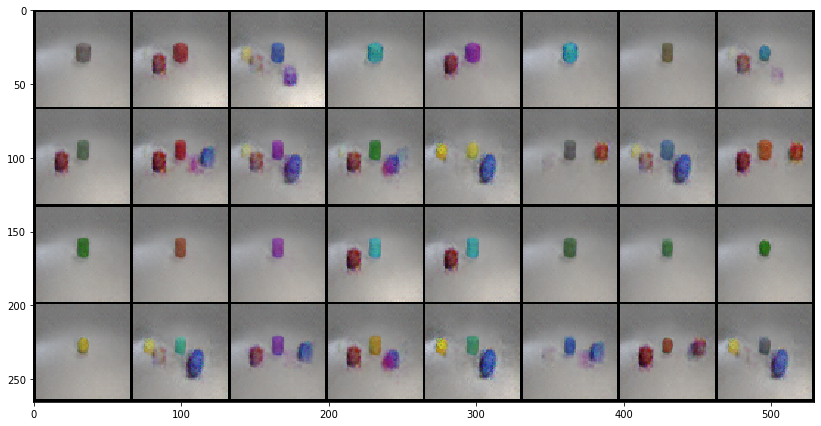

[Epoch 80/100] [D loss: 0.022198] [G loss: 23.394690] [test score: 0.319444]
[Epoch 81/100] [D loss: 0.032472] [G loss: 27.975860] [test score: 0.361111]
[Epoch 82/100] [D loss: 0.023776] [G loss: 27.880092] [test score: 0.263889]
[Epoch 83/100] [D loss: 0.115558] [G loss: 28.917991] [test score: 0.263889]
[Epoch 84/100] [D loss: 0.041218] [G loss: 25.017775] [test score: 0.388889]
[Epoch 85/100] [D loss: 0.013985] [G loss: 25.700003] [test score: 0.305556]
[Epoch 86/100] [D loss: 0.093123] [G loss: 25.013937] [test score: 0.319444]
[Epoch 87/100] [D loss: 0.061010] [G loss: 23.535760] [test score: 0.361111]
[Epoch 88/100] [D loss: 0.016968] [G loss: 27.009787] [test score: 0.361111]
[Epoch 89/100] [D loss: 0.010277] [G loss: 27.899120] [test score: 0.388889]


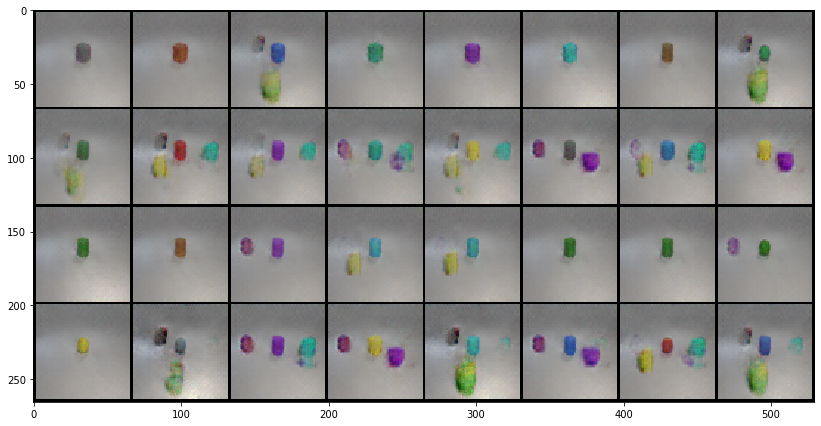

[Epoch 90/100] [D loss: 0.157289] [G loss: 24.659857] [test score: 0.305556]
[Epoch 91/100] [D loss: 0.091592] [G loss: 23.886848] [test score: 0.236111]
[Epoch 92/100] [D loss: 0.073155] [G loss: 23.185341] [test score: 0.333333]
[Epoch 93/100] [D loss: 0.027811] [G loss: 24.050686] [test score: 0.305556]
[Epoch 94/100] [D loss: 0.089969] [G loss: 25.159762] [test score: 0.250000]
[Epoch 95/100] [D loss: 0.014227] [G loss: 25.987098] [test score: 0.291667]
[Epoch 96/100] [D loss: 0.008264] [G loss: 27.058776] [test score: 0.263889]
[Epoch 97/100] [D loss: 0.007195] [G loss: 28.796406] [test score: 0.375000]
[Epoch 98/100] [D loss: 0.005956] [G loss: 29.911068] [test score: 0.333333]
[Epoch 99/100] [D loss: 0.006016] [G loss: 30.442474] [test score: 0.333333]


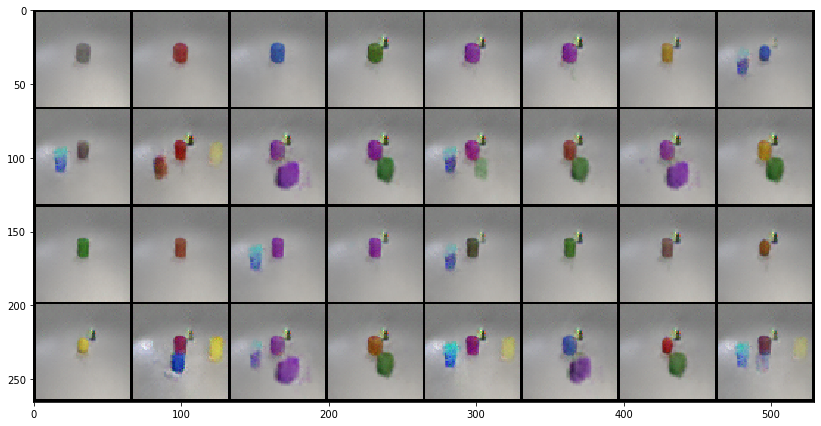

[Epoch 100/100] [D loss: 0.005288] [G loss: 30.565533] [test score: 0.250000]



In [6]:
# training 
epochs = 100
n_critic = 5 # number of training steps for discriminator per iter
save = True
FloatTensor = torch.FloatTensor
LongTensor = torch.LongTensor
g_loss_list = []
d_loss_list = []
max_g_loss = np.inf
max_d_loss = np.inf

for epoch in tqdm.notebook.tqdm(range(epochs)):
    total_d_loss = 0
    total_g_loss = 0
    
    for i, (real_imgs, labels) in enumerate(train_loader):
        batch_size = real_imgs.shape[0]

        real_imgs = real_imgs[:, :3].to(device)
        real_labels = labels.to(device)
        
        # Adversarial ground truths
        valid = Variable(FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False).to(device) # shape [batch_size, 1]
        fake = Variable(FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False).to(device) # shape [batch_size, 1]

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise and labels as generator input
        z = Variable(FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim)))).to(device) # shape [batch_size, latent_dim] with normal distribution
#         gen_labels = Variable(LongTensor(np.random.randint(0, n_classes, (batch_size, 1)))) # shape [batch_size, 1] with 0~24
#         one_hot =  np.zeros((batch_size, n_classes))
#         one_hot[np.arange(batch_size), gen_labels] = 1
#         gen_labels = torch.from_numpy(one_hot).to(device)        
        
        # Generate a batch of images
        gen_imgs = generator(z, real_labels) # shape [batch_size, 3, 64, 64]

        # Loss measures generator's ability to fool the discriminator
        validity = discriminator(gen_imgs, real_labels)
        g_loss = adversarial_loss(validity, valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Loss for real images
        validity_real = discriminator(real_imgs, real_labels)
        d_real_loss = adversarial_loss(validity_real, valid)

        # Loss for fake images
        validity_fake = discriminator(gen_imgs.detach(), real_labels)
        d_fake_loss = adversarial_loss(validity_fake, fake)

        # Total discriminator loss
        d_loss = (d_real_loss + d_fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()
        
        total_d_loss += d_loss.item()
        total_g_loss += g_loss.item()

    score = test_eval(generator, epoch+1)
    total_d_loss /= len(train_loader)
    total_g_loss /= (len(train_loader)/n_critic)
    
    print(
        "[Epoch %d/%d] [D loss: %f] [G loss: %f] [test score: %f]"
        % (epoch+1, epochs, total_d_loss, total_g_loss, score)
    )

    # loss save
    if save:
        save_acc(path+"loss.npz", total_g_loss, total_d_loss, score)
    else:
        g_loss_list.append(total_g_loss)
        d_loss_list.append(total_d_loss)
    
    if save:
        if max_g_loss > total_g_loss:
            max_g_loss = total_g_loss
            torch.save(generator, path+"generator.pt")
        if max_d_loss > total_d_loss:
            max_d_loss = total_d_loss
            torch.save(discriminator, path+"discriminator.pt")

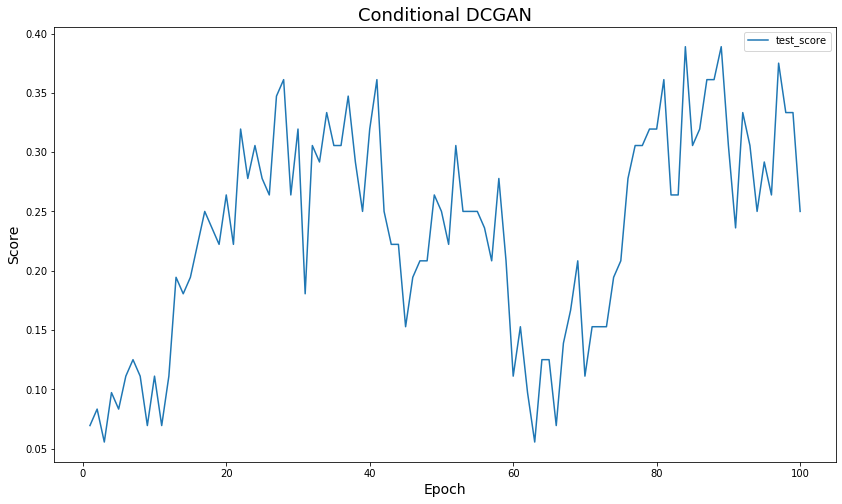

In [7]:
plt.figure(figsize=(14, 8))

load = True
if load:
    acc = np.load(path+"loss.npz")
    g_loss = acc['g_loss']
    d_loss = acc['d_loss']
    score = acc["score"]

plt.title("Conditional DCGAN", fontsize=18)
# plt.ylabel("Loss", fontsize=14)
plt.ylabel("Score", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
x = np.arange(1, len(g_loss)+1)
# plt.plot(x, g_loss, label="g_loss")
# plt.plot(x, d_loss, label="d_loss")
plt.plot(x, score, label="test_score")
plt.legend()
plt.show()

In [8]:
 # step 1: convert it to [0 ,2]
gen_imgs = gen_imgs +1

 # step 2: convert it to [0 ,1]
gen_imgs = gen_imgs - gen_imgs.min()
gen_imgs = gen_imgs / (gen_imgs.max() - gen_imgs.min())

eval_model = evaluation_model()
print(eval_model.eval(gen_imgs, gen_labels))


plt.imshow(np.transpose(gen_imgs[0].detach().cpu().numpy(), (1, 2, 0)))
plt.show()
plt.imshow(np.transpose(gen_imgs[1].detach().cpu().numpy(), (1, 2, 0)))
plt.show()


NameError: name 'gen_labels' is not defined

In [ ]:
eval_model = evaluation_model()
for images, labels in train_loader:
    images = images.to(device)
    labels = labels.to(device)
    out = F.interpolate(images, size=64)  #The resize operation on tensor.
    print(out.shape)
    print(eval_model.eval(images[:, :3], labels))
#     grid = make_grid(out)
    break

In [ ]:
img, label = train.__getitem__(0)
 # step 1: convert it to [0 ,2]
img = img +1

 # step 2: convert it to [0 ,1]
img = img - img.min()
img = img / (img.max() - img.min())

print(img.shape)
plt.imshow(np.transpose(img,(1,2,0)))

In [ ]:
torch.set_printoptions(profile="default")

a = nn.Linear(24, 64*64)     
out = a(gen_labels.cpu().float()).view(-1, 1, 64, 64)
for x, y in train_loader:
    print(out[0].shape)
    print(x[0].shape)
    out = torch.cat((out[0], x[0][:3]), dim=0)
    img = out.detach().cpu().numpy()
     # step 1: convert it to [0 ,2]
    img = img +1

     # step 2: convert it to [0 ,1]
    img = img - img.min()
    img = img / (img.max() - img.min())
    plt.imshow(np.transpose(img,(1,2,0)))
    break